In [44]:

import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import caffe
from skimage.metrics import (
    peak_signal_noise_ratio as psnr,
    structural_similarity as ssim,
)
from PIL import Image

In [45]:
brain_idx=4 # options: 1, 2, 3, 4
# To visualize images:
# Image 1: np.rot90(k=1)
# Image 2: np.rot90(k=-1)
# Image 3: np.rot90(k=-1)
# Image 4: np.rot90(k=-1)

In [46]:
mat = scipy.io.loadmat(f"/mnt/data_drive/hrodrigo/mri_rician_noise/.riciannet/RicianNet/testdata/Brain{brain_idx}.mat")
noiseSigma = 15
# mat['Img'] returns the same brain!
brain_not_normalized = mat["Img"]
brain = brain_not_normalized / np.abs(brain_not_normalized).max()
# Add Rician noise
level = noiseSigma * np.abs(brain).max() / 100
n1 = level * np.random.randn(*np.abs(brain).shape) + brain.real
n2 = level * np.random.randn(*np.abs(brain).shape) + brain.imag

brain_real = np.abs(brain)

in_img = np.sqrt(n1**2 + n2**2)

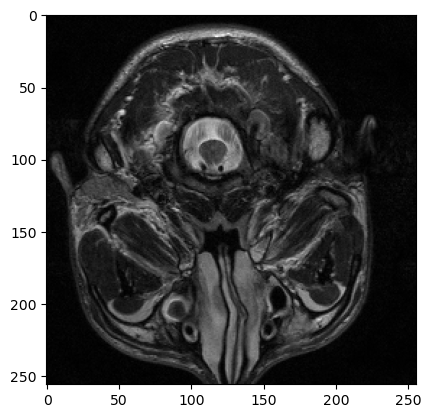

In [47]:
plt.imshow(np.rot90(brain_real[:256,:256], k=-1 if brain_idx != 1 else 1), cmap="gray")
plt.show()

In [48]:
prototext_path = "/mnt/data_drive/hrodrigo/mri_rician_noise/.riciannet/RicianNet/Riciannet_deploy.prototxt"
weights_path = "/mnt/data_drive/hrodrigo/mri_rician_noise/.riciannet/RicianNet/model/N15_complex_Brain1&2.caffemodel"


caffe.set_mode_cpu()  # Use caffe.set_mode_gpu() if you want to use GPU



In [49]:
net = caffe.Net(prototext_path, weights_path, caffe.TEST)

W0123 18:08:11.977694 43581 _caffe.cpp:139] DEPRECATION WARNING - deprecated use of Python interface
W0123 18:08:11.977721 43581 _caffe.cpp:140] Use this instead (with the named "weights" parameter):
W0123 18:08:11.977726 43581 _caffe.cpp:142] Net('/mnt/data_drive/hrodrigo/mri_rician_noise/.riciannet/RicianNet/Riciannet_deploy.prototxt', 1, weights='/mnt/data_drive/hrodrigo/mri_rician_noise/.riciannet/RicianNet/model/N15_complex_Brain1&2.caffemodel')
I0123 18:08:11.986135 43581 upgrade_proto.cpp:67] Attempting to upgrade input file specified using deprecated input fields: /mnt/data_drive/hrodrigo/mri_rician_noise/.riciannet/RicianNet/Riciannet_deploy.prototxt
I0123 18:08:11.986155 43581 upgrade_proto.cpp:70] Successfully upgraded file specified using deprecated input fields.
W0123 18:08:11.986160 43581 upgrade_proto.cpp:72] Note that future Caffe releases will only support input layers and not input fields.
I0123 18:08:11.986164 43581 upgrade_proto.cpp:77] Attempting to upgrade batch n

In [50]:

result = net.forward(data=np.rot90(in_img, k=-1 if brain_idx != 1 else 1)[None, None, ...])
result_conv13 = result["conv13"].squeeze().clip(0., 1.)

:12.030025 43581 net.cpp:367] scale_conv8 -> conv8 (in-place)
I0123 18:08:12.030031 43581 layer_factory.hpp:77] Creating layer scale_conv8
I0123 18:08:12.030346 43581 net.cpp:122] Setting up scale_conv8
I0123 18:08:12.030351 43581 net.cpp:129] Top shape: 1 128 256 270 (8847360)
I0123 18:08:12.030355 43581 net.cpp:137] Memory required for data: 603002880
I0123 18:08:12.030359 43581 layer_factory.hpp:77] Creating layer relu8
I0123 18:08:12.030364 43581 net.cpp:84] Creating Layer relu8
I0123 18:08:12.030367 43581 net.cpp:406] relu8 <- conv8
I0123 18:08:12.030371 43581 net.cpp:367] relu8 -> conv8 (in-place)
I0123 18:08:12.030375 43581 net.cpp:122] Setting up relu8
I0123 18:08:12.030378 43581 net.cpp:129] Top shape: 1 128 256 270 (8847360)
I0123 18:08:12.030381 43581 net.cpp:137] Memory required for data: 638392320
I0123 18:08:12.030385 43581 layer_factory.hpp:77] Creating layer conv9
I0123 18:08:12.030390 43581 net.cpp:84] Creating Layer conv9
I0123 18:08:12.030392 43581 net.cpp:406] conv9

In [51]:
mask_path=f'/mnt/data_drive/hrodrigo/mri_rician_noise/deep-image-prior/.brainweb_test_data/im_{9+brain_idx}/mask.png'

mask = np.array(Image.open(mask_path).convert("L")) / 255
print(mask.min(),mask.max())



0.0 1.0


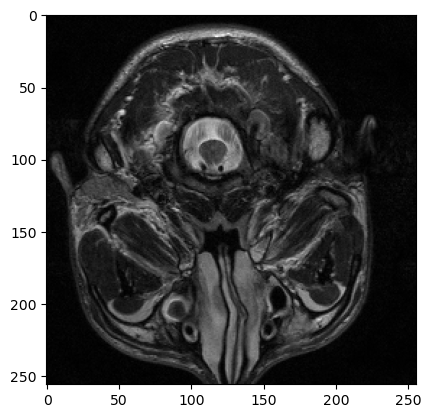

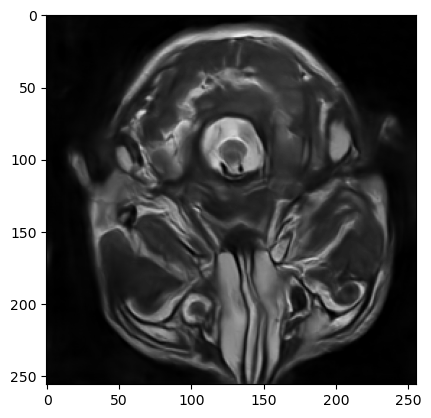

In [52]:
plt.imshow(np.rot90(brain_real[:256,:256], k=-1 if brain_idx != 1 else 1), cmap="gray")
plt.show()
plt.imshow(result_conv13[:256,:256], cmap="gray")
plt.show()




In [53]:
def psnr_with_mask(
    img_1: np.ndarray,
    img_2: np.ndarray,
    mask: np.ndarray,
    data_range=1.0,
):
    mask_size = (mask > 0).sum().item()
    mse = ((img_1 - img_2) ** 2 * mask).sum() / mask_size
    return 10 * np.log10(data_range**2 / mse)

In [54]:
maskless_psnr = psnr(
        result_conv13[:256, :256],
        np.rot90(brain_real,k=-1 if brain_idx != 1 else 1)[:256, :256],
        data_range=1.0,
    )
mask_psnr = psnr_with_mask(
        np.rot90(brain_real, k=-1 if brain_idx != 1 else 1)[:256, :256],
        result_conv13[:256, :256],
        mask
    )

print('--- PSNR values ---')
print(f'with mask: {mask_psnr}')
print(f'without mask: {maskless_psnr}')


--- PSNR values ---
with mask: 24.58397995069255
without mask: 26.22686018218701


# Results report

Im1 - PSNR (with mask, -less): 26.44 dB, **26.70** dB

Im2 - PSNR (with mask, -less): 26.97 dB, **27.97** dB

Im3 - PSNR (with mask, -less): 26.69 dB, **27.25** dB

Im4 - PSNR (with mask, -less): 24.58 dB, **26.22** dB